<h2 style="color:dodgerblue"> 
ISEF 2024-25 Project
</h2>

<h4 style="color:white"> 
Quantum Error Correction Codes: Accuracy vs Time Complexity
</h4>

##### <span style="color: white;"> By: Sumer Chaudhary, BASIS Independent McLean
______________________
<h6 style="color:dodgerblue"> 
12/15/2024 - 
</h6>

In [28]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister, generate_preset_pass_manager, transpile
from qiskit.visualization import plot_histogram, plot_circuit_layout
from qiskit.quantum_info import Statevector, Operator
from qiskit.quantum_info.operators import SparsePauliOp
from qiskit.circuit import IfElseOp
import numpy as np
from qiskit_ibm_runtime import QiskitRuntimeService

service=QiskitRuntimeService()

In [2]:
def cxx(qc, c, q1, q2):
    qc.cx(c, q1)
    qc.cx(c, q2)

def cxxx(qc, c, q1, q2, q3):
    qc.cx(c, q1)
    qc.cx(c, q2)
    qc.cx(c, q3)

def cxxxx(qc, c, q1, q2, q3, q4): 
    qc.cx(c,q1)
    qc.cx(c,q2)
    qc.cx(c,q3)
    qc.cx(c,q4)

def czz(qc, c, q1, q2):
    qc.cz(c, q1)
    qc.cz(c, q2)

def czzz(qc, c, q1, q2, q3):
    qc.cz(c, q1)
    qc.cz(c, q2)
    qc.cz(c, q3)

def czzzz(qc, c, q1, q2, q3, q4): 
    qc.cz(c,q1)
    qc.cz(c,q2)
    qc.cz(c,q3)
    qc.cz(c,q4)

In [55]:
def encode_with_shors(qc, log_reg, stab_reg):
    cxx(qc, log_reg[0], stab_reg[2], stab_reg[5])

    qc.h(log_reg[0])
    qc.h(stab_reg[2])
    qc.h(stab_reg[5])

    cxx(qc, log_reg[0], stab_reg[0], stab_reg[1])

    cxx(qc, stab_reg[2], stab_reg[3], stab_reg[4])

    cxx(qc, stab_reg[5], stab_reg[6], stab_reg[7])

    qc.barrier()


def decode_with_shors(qc, log_reg, class_reg, stab_reg):
    cxx(qc, log_reg[0], stab_reg[0], stab_reg[1])

    cxx(qc, stab_reg[2], stab_reg[3], stab_reg[4])

    cxx(qc, stab_reg[5], stab_reg[6], stab_reg[7])

    qc.ccx(stab_reg[1], stab_reg[0], log_reg[0])
    qc.ccx(stab_reg[4], stab_reg[3], stab_reg[2])
    qc.ccx(stab_reg[7], stab_reg[6], stab_reg[5])

    qc.h(log_reg[0])
    qc.h(stab_reg[2])
    qc.h(stab_reg[5])

    cxx(qc, log_reg[0], stab_reg[2], stab_reg[5])

    qc.ccx(stab_reg[5], stab_reg[2], log_reg[0])

    qc.barrier()

In [4]:
def steane_error_correction(qc, x_ancillas, z_ancillas, logical_qubit, x_syndrome, z_syndrome):
    # Initialize the ancillas to |0>
    for i in range(3):
        qc.initialize([1,0], x_ancillas[i])
        qc.initialize([1,0], z_ancillas[i])
        
    # Apply Hadamard to the ancillas
    qc.h(x_ancillas)
    qc.h(z_ancillas)
    
    # Controlled g_i
    qc.cx(z_ancillas[2], [logical_qubit[i-1] for i in [4,5,6,7]]) # Controlled g1
    qc.cx(z_ancillas[1], [logical_qubit[i-1] for i in [2,3,6,7]]) # Controlled g2
    qc.cx(z_ancillas[0], [logical_qubit[i-1] for i in [1,3,5,7]]) # Controlled g3
    
    qc.cz(x_ancillas[2], [logical_qubit[i-1] for i in [4,5,6,7]]) # Controlled g4
    qc.cz(x_ancillas[1], [logical_qubit[i-1] for i in [2,3,6,7]]) # Controlled g5
    qc.cz(x_ancillas[0], [logical_qubit[i-1] for i in [1,3,5,7]]) # Controlled g6
    
    # Apply Hadamard to the ancillas
    qc.h(x_ancillas)
    qc.h(z_ancillas)
    
    # Measure the ancillas
    qc.measure(x_ancillas, x_syndrome)
    qc.measure(z_ancillas,z_syndrome)
    
    # Apply the corrective X gates
    for i in range(1,8):
        qc.x(logical_qubit[i-1]).c_if(x_syndrome,i)
    
    # Apply the corrective Z gates
    for i in range(1,8):
        qc.z(logical_qubit[i-1]).c_if(z_syndrome,i)

# Adds the logical Hadamard  gate to a QuantumCircuit qc
def logical_h(qc, logical_qubit):
    if not isinstance(qc, QuantumCircuit):
        raise TypeError("'qc', should be a QuantumCircuit")
        
    if not isinstance(logical_qubit, QuantumRegister):
        raise TypeError("'logical_qubit' should be a QuantumRegister")
    elif logical_qubit.size != 7:
        raise TypeError("'logical_qubit' must have 7 qubits")

    qc.h(logical_qubit)

# Adds the logical CNOT gate to a QuantumCircuit qc with logical qubit 'control' as the control
# and 'target' as target
def logical_cx(qc, control, target):
    if not isinstance(qc, QuantumCircuit):
        raise TypeError("'qc', should be a QuantumCircuit")
        
    if not isinstance(control, QuantumRegister):
        raise TypeError("'control' should be a QuantumRegister")
    elif control.size != 7:
        raise TypeError("'control' must have 7 qubits")
    
    if not isinstance(control, QuantumRegister):
        raise TypeError("'control' should be a QuantumRegister")
    elif control.size != 7:
        raise TypeError("'control' must have 7 qubits")

    for i in range(7):
        qc.cx(control[i],target[i])

# Measures logical_qubit in the Z basis using ancilla, in the circuit qc
def logical_z_measure(qc, ancilla, logical_qubit, measurement):
    # Make sure the inputs are valid
    if not isinstance(qc, QuantumCircuit):
        raise TypeError("'qc' should be a QuantumCircuit")
    
    if not isinstance(ancilla, QuantumRegister):
        raise TypeError("'ancilla' should be a QuantumRegister")
    elif ancilla.size != 1:
        raise TypeError("'ancilla' must have 1 qubit")
    
    if not isinstance(logical_qubit, QuantumRegister):
        raise TypeError("'logical_qubit'should be a QuantumRegister")
    elif logical_qubit.size != 7:
        raise TypeError("'logical_qubit' must have 7 qubits")
    
    if not isinstance(measurement, ClassicalRegister):
        raise TypeError("'measurement' should be a ClassicalRegister")
    elif measurement.size != 1:
        raise TypeError("'measurement' must have 1 bit")
        
    # Initialize ancilla to |0>
    qc.initialize([1,0],ancilla)
    
    # Apply Hadamard to ancilla
    qc.h(ancilla)
    # Apply controlled logical-Z
    for i in range(7):
        qc.cz(ancilla, logical_qubit[i])
    # Apply Hadamard to ancilla
    qc.h(ancilla)
    
    # Measure the ancilla
    qc.measure(ancilla, measurement)

In [22]:
def encode_with_steane(qc, lq, stab_reg):
    cxx(qc, lq, stab_reg[4], stab_reg[5])
    
    qc.h(stab_reg[:3])
        
    cxxx(qc, stab_reg[0], stab_reg[3], stab_reg[5], lq)

    cxxx(qc, stab_reg[1], stab_reg[3], stab_reg[4], lq)

    cxxx(qc, stab_reg[2], stab_reg[3], stab_reg[4], stab_reg[5])

    qc.barrier()

def steane_measure_syndrome(qc, lq, stab_reg, anc_reg, class_reg):
    qc.h(anc_reg[:6])

    cxxxx(qc, anc_reg[0], stab_reg[0], stab_reg[4], stab_reg[5], lq)
    cxxxx(qc, anc_reg[1], stab_reg[1], stab_reg[3], stab_reg[5], lq)
    cxxxx(qc, anc_reg[2], stab_reg[2], stab_reg[3], stab_reg[4], stab_reg[5])
    
    czzzz(qc, anc_reg[3], stab_reg[0], stab_reg[4], stab_reg[5], lq)
    czzzz(qc, anc_reg[4], stab_reg[1], stab_reg[3], stab_reg[5], lq)
    czzzz(qc, anc_reg[5], stab_reg[2], stab_reg[3], stab_reg[4], stab_reg[5])

    qc.h(anc_reg)    
    qc.measure(anc_reg, class_reg)

    qc.barrier()


def steane_correct_errors(qc, lq, stab_reg, class_reg):
    # Define correction gates using a mapping of the table values.
    def apply_correction(circuit, correction, qubit):
        if correction == "X":
            circuit.x(qubit)
        elif correction == "Z":
            circuit.z(qubit)
        elif correction == "Y":
            circuit.y(qubit)
        elif correction == "I":
            circuit.i(qubit) #does nothing, just to be there

    corrections = { # All of them are the Y errors, as the first half of the number would be the Z error, and the second, the X
    36: stab_reg[0],
    18: stab_reg[1],
    9:  stab_reg[2],
    54: stab_reg[3],
    45: stab_reg[4],
    63: stab_reg[5],
    27: lq
    }

    # Iterate through all correction cases from the table.
    for decimal_value, qubit in corrections.items():
        # Prepare the classical condition for the current value.
        one_vals = []
        condition = [int(x) for x in format(decimal_value, '06b')]
        control_ops = []
        for i, value in enumerate(condition):
            if value==1:
                one_vals.append(i-len(one_vals))
            control_ops.append(qc.if_test((class_reg[i], value)))

        for i in range(len(one_vals)):
            if_test = control_ops.pop(one_vals[i])
            control_ops.append(if_test)

        
        one_vals = [] #clear the one_vals, as they are no longer correct
        
        for i in range(len(control_ops)): 
            if control_ops[i].condition[1]==1:
                one_vals.append(i)

        # Split the one_vals into Z and X checks for the Y condition.
        z_checks = one_vals[:len(one_vals) // 2]  # First half corresponds to Z checks.
        x_checks = one_vals[len(one_vals) // 2 : len(one_vals)]  # Second half corresponds to X checks.
        
        
        # Apply the correction for the matched condition.
        if z_checks[0] != 0:
            with control_ops[0]:
                with control_ops[1]:
                    if z_checks[0] != 2:
                        with control_ops[2]:
                            with control_ops[3]:
                                if z_checks[0] != 4: #if we reach this point, z_checks should always be 4, this is just for safety
                                    with control_ops[4]:
                                        with control_ops[5]:
                                            apply_correction(qc, "I", qubit)

                                else: #2 bits need to be one
                                    with control_ops[z_checks[0]] as else1:
                                        with control_ops[x_checks[0]] as else2:
                                            apply_correction(qc, "Y", qubit)
                                        with else2:
                                            apply_correction(qc, "Z", qubit)
                                    with else1:
                                        with control_ops[x_checks[0]]:
                                            apply_correction(qc, "X", qubit)
                                        
                    else: #4 bits need to be one
                        with control_ops[z_checks[0]] as else1:
                            with control_ops[z_checks[1]]:
                                with control_ops[x_checks[0]] as else2:
                                    with control_ops[x_checks[1]]:
                                        apply_correction(qc, "Y", qubit)
                                with else2:
                                    apply_correction(qc, "Z", qubit)    
                        with else1:
                            with control_ops[x_checks[0]]:
                                 with control_ops[x_checks[1]]:
                                    apply_correction(qc, "X", qubit)
                                     
        else: #All 6 bits need to be one
            with control_ops[z_checks[0]] as else1:
                with control_ops[z_checks[1]]:
                    with control_ops[z_checks[2]]:
                        with control_ops[x_checks[0]] as else2:
                            with control_ops[x_checks[1]]:
                                with control_ops[x_checks[2]]:
                                    apply_correction(qc, "Y", qubit)
                        with else2:
                            apply_correction(qc, "Z", qubit)
            with else1:
                with control_ops[x_checks[0]]:
                    with control_ops[x_checks[1]]:
                        with control_ops[x_checks[2]]:
                            apply_correction(qc, "X", qubit)


    qc.barrier()

    
def decode_with_steane(qc, lq, stab_reg, output_reg):
    qc.cx(stab_reg[0], output_reg[0])
    qc.cx(stab_reg[1], output_reg[0])

    qc.cx(lq, output_reg[0])

    cxxx(qc, output_reg[0], stab_reg[4], stab_reg[5], lq)

    qc.barrier()

In [ ]:
def encode_with_steane(qc, lq, stab_reg):
    

In [42]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
""", errors
from qiskit_aer.noise.errors import depolarizing_error, readout_error
 
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(
    50e3, 10e3, 4
)  # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(
    70e3, 10e3, 4
)  # Sampled from normal distribution mean 50 microsec
 
# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])
 
# Instruction times (in nanoseconds)
time_u1 = 0  # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100  # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000  # 1 microsecond
 
# QuantumError objects
errors_reset = [
    errors.thermal_relaxation_error(t1, t2, time_reset) for t1, t2 in zip(T1s, T2s)
]
errors_measure = [
    errors.thermal_relaxation_error(t1, t2, time_measure) for t1, t2 in zip(T1s, T2s)
]
errors_u1 = [
    errors.thermal_relaxation_error(t1, t2, time_u1) for t1, t2 in zip(T1s, T2s)
]
errors_u2 = [
    errors.thermal_relaxation_error(t1, t2, time_u2) for t1, t2 in zip(T1s, T2s)
]
errors_u3 = [
    errors.thermal_relaxation_error(t1, t2, time_u3) for t1, t2 in zip(T1s, T2s)
]
errors_cx = [
    [
        errors.thermal_relaxation_error(t1a, t2a, time_cx).expand(
            errors.thermal_relaxation_error(t1b, t2b, time_cx)
        )
        for t1a, t2a in zip(T1s, T2s)
    ]
    for t1b, t2b in zip(T1s, T2s)
]
 
# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])"""

backend_name = "ibm_brisbane"
quantBackend = service.backend(backend_name)

noise_model = NoiseModel.from_backend(quantBackend)
backend = AerSimulator(noise_model=noise_thermal, method="matrix_product_state")

passmanager = generate_preset_pass_manager(
    optimization_level=3, backend=backend
)

<h3 style="color:white"> 
Control Group
</h4>

In [43]:
q = QuantumRegister(2, 'q')
c = ClassicalRegister(2, 'c')
qc = QuantumCircuit(q,c)

#Bell State
qc.h(q[0])
qc.cx(q[0],q[1])

#Measure
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])

qc.draw("mpl", initial_state=True, scale=0.5, fold=-1, style="clifford", reverse_bits=False, plot_barriers=False, filename="Diagrams/control.png")

noisy_circ = passmanager.run(qc)

result = backend.run(noisy_circ, shots=8192).result()
plot_histogram(result.get_counts(0), filename="Results/control.png")

<h3 style="color:white"> 
Shor's Error Correction Code
</h3>

In [46]:
q1 = QuantumRegister(1, 'q1')
q2 = QuantumRegister(1, 'q2')
c = ClassicalRegister(2,'c')
a1 = AncillaRegister(8, 'a1')
a2 = AncillaRegister(8, 'a2')
qc = QuantumCircuit(q1,a1,q2,a2,c)

qc.initialize(0, a1)
qc.initialize(0, a2)

qc.barrier()

#Bell State
qc.h(q1[0])
qc.cx(q1[0],q2[0])

qc.barrier()

#Encode
encode_with_shors(qc, q1, a1)
encode_with_shors(qc, q2, a2)

#Decode
decode_with_shors(qc, q1, c, a1)
decode_with_shors(qc, q2, c, a2)

#Measure
qc.measure(q1[0], c[0])
qc.measure(q2[0], c[1])

qc.draw("mpl", initial_state=True, scale=0.5, fold=-1, style="clifford", reverse_bits=False, plot_barriers=False, filename="Diagrams/shor.png")

noisy_circ = passmanager.run(qc)

result = backend.run(noisy_circ, shots=8192).result()

plot_histogram(result.get_counts(0), filename="Results/shor.png")

<h3 style="color:white"> 
Steane Error Correction Code
</h3>

In [9]:
# The logical qubits
lq_1 = QuantumRegister(7,name='lq_1')
lq_2 = QuantumRegister(7,name='lq_2')

# Error Correction Ancillas
x_ec_ancilla = QuantumRegister(3,name='x_ec_ancil')
z_ec_ancilla = QuantumRegister(3,name='z_ec_ancil')

x_ec_syndrome = ClassicalRegister(3,name='x_ec_synd')
z_ec_syndrome = ClassicalRegister(3,name='z_ec_synd')

# Measurement Ancillas
z_meas_ancilla_1 = QuantumRegister(1,name='meas_ancil_1')
z_meas_ancilla_2 = QuantumRegister(1,name='meas_ancil_2')

z_meas_1 = ClassicalRegister(1,name='meas 1')
z_meas_2 = ClassicalRegister(1,name='meas 2')

# Define the quantum circuit on these registers
qc = QuantumCircuit(lq_1, lq_2,
                    x_ec_ancilla, z_ec_ancilla, z_meas_ancilla_1, z_meas_ancilla_2,
                    x_ec_syndrome, z_ec_syndrome, z_meas_1, z_meas_2)

# Apply the Hadamard gate
logical_h(qc, lq_1)    

# Apply the CNOT gate
logical_cx(qc, lq_1, lq_2)

qc.barrier()

steane_error_correction(qc, x_ec_ancilla, z_ec_ancilla, lq_1, x_ec_syndrome, z_ec_syndrome)
steane_error_correction(qc, x_ec_ancilla, z_ec_ancilla, lq_2, x_ec_syndrome, z_ec_syndrome)

# Measure the qubits
logical_z_measure(qc, z_meas_ancilla_1, lq_1, z_meas_1)
logical_z_measure(qc, z_meas_ancilla_2, lq_2, z_meas_2)

#qc.draw("mpl", initial_state=True, scale=0.5, fold=-1, style="clifford", reverse_bits=False, plot_barriers=False, filename="Diagrams/steane.png")

/var/folders/m1/m9y8lmf94db5f24wfgkkb1l80000gn/T/ipykernel_8493/3719194965.py:30: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.x(logical_qubit[i-1]).c_if(x_syndrome,i)
/var/folders/m1/m9y8lmf94db5f24wfgkkb1l80000gn/T/ipykernel_8493/3719194965.py:34: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.z(logical_qubit[i-1]).c_if(z_syndrome,i)


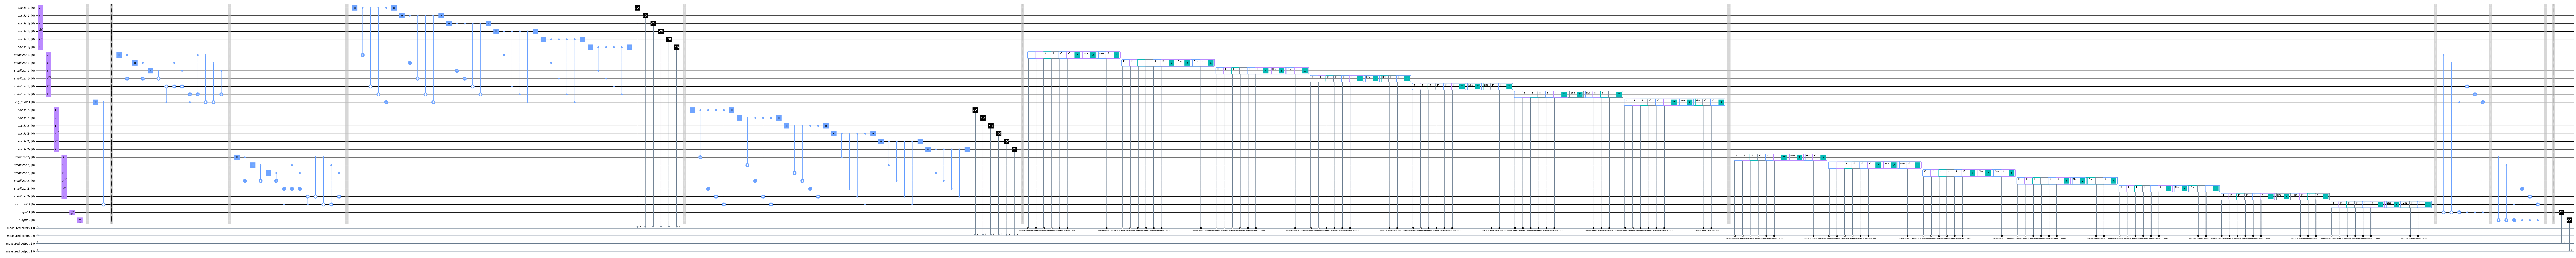

In [47]:
q1 = QuantumRegister(1, 'log_qubit 1')
s1 = AncillaRegister(6, 'stabilizer 1')
o1 = AncillaRegister(1, 'output 1')
a1 = AncillaRegister(6, 'ancilla 1')
c1 = ClassicalRegister(6, 'measured errors 1')
r1 = ClassicalRegister(1, 'measured output 1')
q2 = QuantumRegister(1, 'log_qubit 2')
s2 = AncillaRegister(6, 'stabilizer 2')
o2 = AncillaRegister(1, 'output 2')
a2 = AncillaRegister(6, 'ancilla 2')
c2 = ClassicalRegister(6, 'measured errors 2')
r2 = ClassicalRegister(1, 'measured output 2')
qc = QuantumCircuit(a1, s1, q1, a2, s2, q2, o1, o2, c1, c2, r1, r2)

#qc.reset(range(qc.num_qubits))

qc.initialize(0, s1)
qc.initialize(0, o1)
qc.initialize(0, a1)
qc.initialize(0, s2)
qc.initialize(0, o2)
qc.initialize(0, a2)

qc.barrier()

qc.h(q1[0])
qc.cx(q1[0], q2[0])

qc.barrier()

#Encode Qubits
encode_with_steane(qc, q1[0], s1)
encode_with_steane(qc, q2[0], s2)

#Measure Syndrome
steane_measure_syndrome(qc, q1[0], s1, a1, c1)
steane_measure_syndrome(qc, q2[0], s2, a2, c2)

#Correct Errors
steane_correct_errors(qc, q1[0], s1, c1)
steane_correct_errors(qc, q2[0], s2, c2)

#Decode Qubits
decode_with_steane(qc, q1[0], s1, o1)
decode_with_steane(qc, q2[0], s2, o2)

qc.barrier()

#Measure Output
qc.measure(o1[0], r1[0])
qc.measure(o2[0], r2[0])

noisy_circ=passmanager.run(qc)

qc.draw("mpl", style="clifford", scale=0.75, fold=-1, plot_barriers=True, initial_state=True, justify="none")

## Check circuit properties
#print("Depth:", qc.depth())
#print("Number of qubits:", qc.num_qubits)
#print("Number of gates:", qc.size())

In [50]:
result = backend.run(noisy_circ, shots=8192).result()

In [52]:
proc_results = {"0 0" : 0, "0 1" : 0, "1 0" : 0, "1 1" : 0}
for res in result.get_counts(0):
    proc_results[res[:3]] += result.get_counts(0)[res]
plot_histogram(proc_results, filename="Results/steane.png")

<h3 style="color:white"> 
Five-qubit Error Correction Code
</h3>

515.2096660137177


64
